In [2]:
# Cell 1: Imports
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import pandas as pd
from tqdm import tqdm

from src.models.model import create_model
from src.data.dataset import DataLoaderFactory
from src.data.preprocessing import DataAugmentation

print("✅ All imports successful!")


✅ All imports successful!


In [3]:

# Cell 2: Load Model and Data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Configuration
MODEL_NAME = 'resnet50'
NUM_CLASSES = 4
CLASS_NAMES = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
MODEL_PATH = '../models/saved/resnet50_best.pth'

# Load model
model = create_model(MODEL_NAME, num_classes=NUM_CLASSES, pretrained=False)
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✅ Model loaded (Best Val Acc: {checkpoint['best_val_acc']:.2f}%)")

# Load test data
TRAIN_DIR = '../data/processed/train'
VAL_DIR = '../data/processed/val'
TEST_DIR = '../data/processed/test'

train_transform = DataAugmentation.get_train_transform()
test_transform = DataAugmentation.get_val_transform()

_, _, test_loader, _ = DataLoaderFactory.create_dataloaders(
    TRAIN_DIR, VAL_DIR, TEST_DIR,
    train_transform, test_transform,
    batch_size=32,
    num_workers=2,
    use_weighted_sampling=False  # No sampling for test
)

print(f"✅ Test set loaded: {len(test_loader)} batches")



Device: cuda
  Training from scratch
✅ Built resnet50 with 4 output classes
✅ Model loaded (Best Val Acc: 96.13%)
Creating datasets...
✅ Loaded 14814 images from 4 classes

Class Distribution in ../data/processed/train:
--------------------------------------------------
  COVID                :  2531 (17.09%)
  Lung_Opacity         :  4208 (28.41%)
  Normal               :  7134 (48.16%)
  Viral Pneumonia      :   941 ( 6.35%)
--------------------------------------------------
✅ Loaded 3175 images from 4 classes

Class Distribution in ../data/processed/val:
--------------------------------------------------
  COVID                :   542 (17.07%)
  Lung_Opacity         :   902 (28.41%)
  Normal               :  1529 (48.16%)
  Viral Pneumonia      :   202 ( 6.36%)
--------------------------------------------------
✅ Loaded 3176 images from 4 classes

Class Distribution in ../data/processed/test:
--------------------------------------------------
  COVID                :   543 (17.10%)


In [4]:
# Cell 3: Evaluate on Test Set
print("\nEvaluating on test set...")
print("This will take 3-5 minutes...\n")

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print("✅ Evaluation complete!")



Evaluating on test set...
This will take 3-5 minutes...



Testing: 100%|██████████| 100/100 [00:15<00:00,  6.33it/s]

✅ Evaluation complete!


In [5]:

# Cell 4: Calculate Metrics
# Overall metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted'
)

# Per-class metrics
precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None
)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# ROC-AUC (multiclass)
auc_scores = []
for i in range(NUM_CLASSES):
    # One-vs-rest approach
    y_true_binary = (all_labels == i).astype(int)
    y_scores = all_probs[:, i]
    auc = roc_auc_score(y_true_binary, y_scores)
    auc_scores.append(auc)

avg_auc = np.mean(auc_scores)

print("\n" + "="*70)
print("OVERALL TEST SET PERFORMANCE")
print("="*70)
print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {avg_auc:.4f}")
print("="*70)




OVERALL TEST SET PERFORMANCE
Accuracy:  95.56%
Precision: 0.9558
Recall:    0.9556
F1-Score:  0.9554
ROC-AUC:   0.9944


In [6]:
# Cell 5: Per-Class Performance Table
results_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support,
    'ROC-AUC': auc_scores
})

print("\n" + "="*70)
print("PER-CLASS PERFORMANCE")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Save results
results_df.to_csv('../results/metrics/test_set_performance.csv', index=False)
print("\n✅ Results saved to: ../results/metrics/test_set_performance.csv")




PER-CLASS PERFORMANCE
          Class  Precision   Recall  F1-Score  Support  ROC-AUC
          COVID   0.986965 0.976059  0.981481      543 0.999477
   Lung_Opacity   0.952381 0.909091  0.930233      902 0.988518
         Normal   0.943456 0.971223  0.957138     1529 0.989637
Viral Pneumonia   0.980392 0.990099  0.985222      202 0.999860

✅ Results saved to: ../results/metrics/test_set_performance.csv


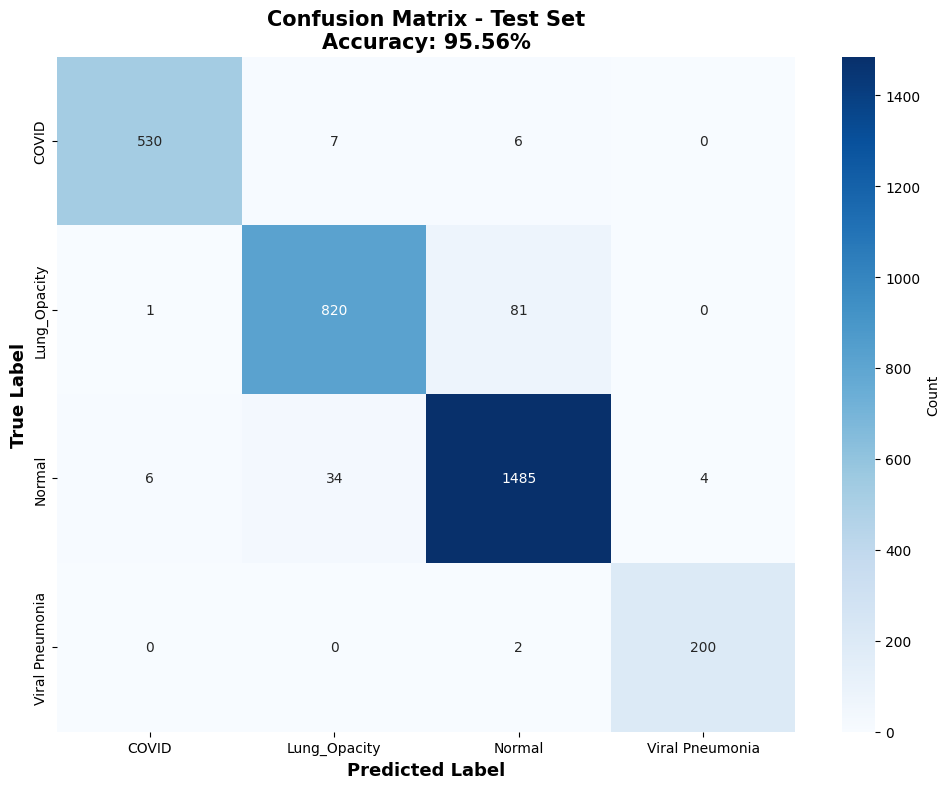

In [7]:
# Cell 6: Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'}, ax=ax)

ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax.set_title(f'Confusion Matrix - Test Set\nAccuracy: {accuracy*100:.2f}%', 
             fontsize=15, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/plots/confusion_matrix_test.png', dpi=300, bbox_inches='tight')
plt.show()



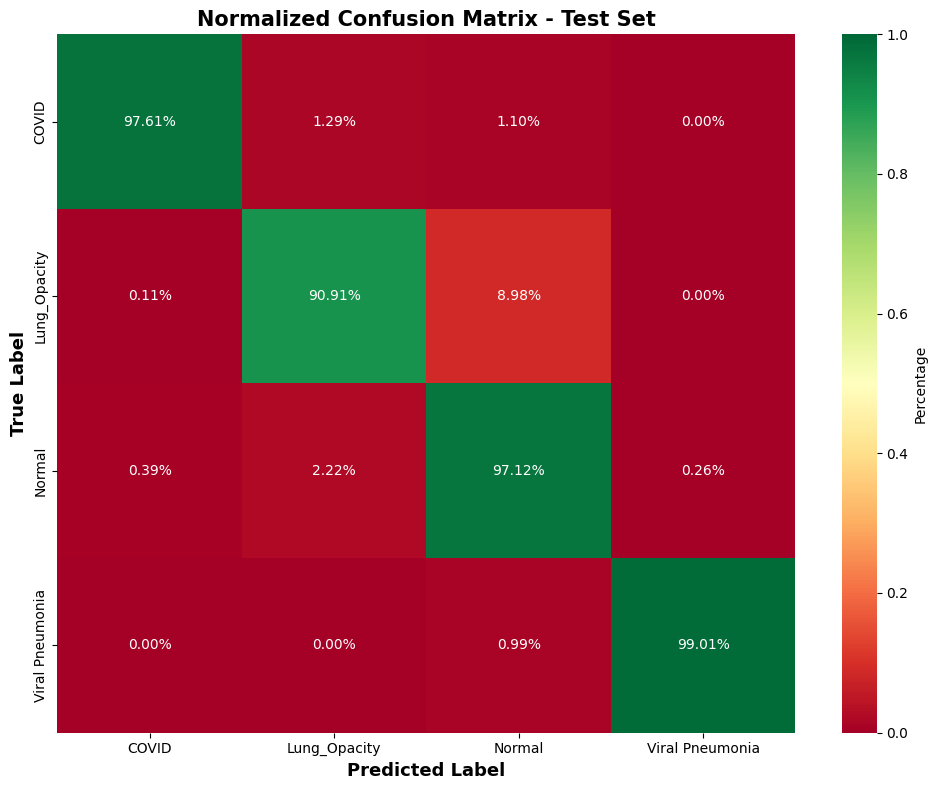

In [8]:
# Cell 7: Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Percentage'}, ax=ax, vmin=0, vmax=1)

ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
ax.set_title('Normalized Confusion Matrix - Test Set', 
             fontsize=15, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/plots/confusion_matrix_normalized_test.png', dpi=300, bbox_inches='tight')
plt.show()



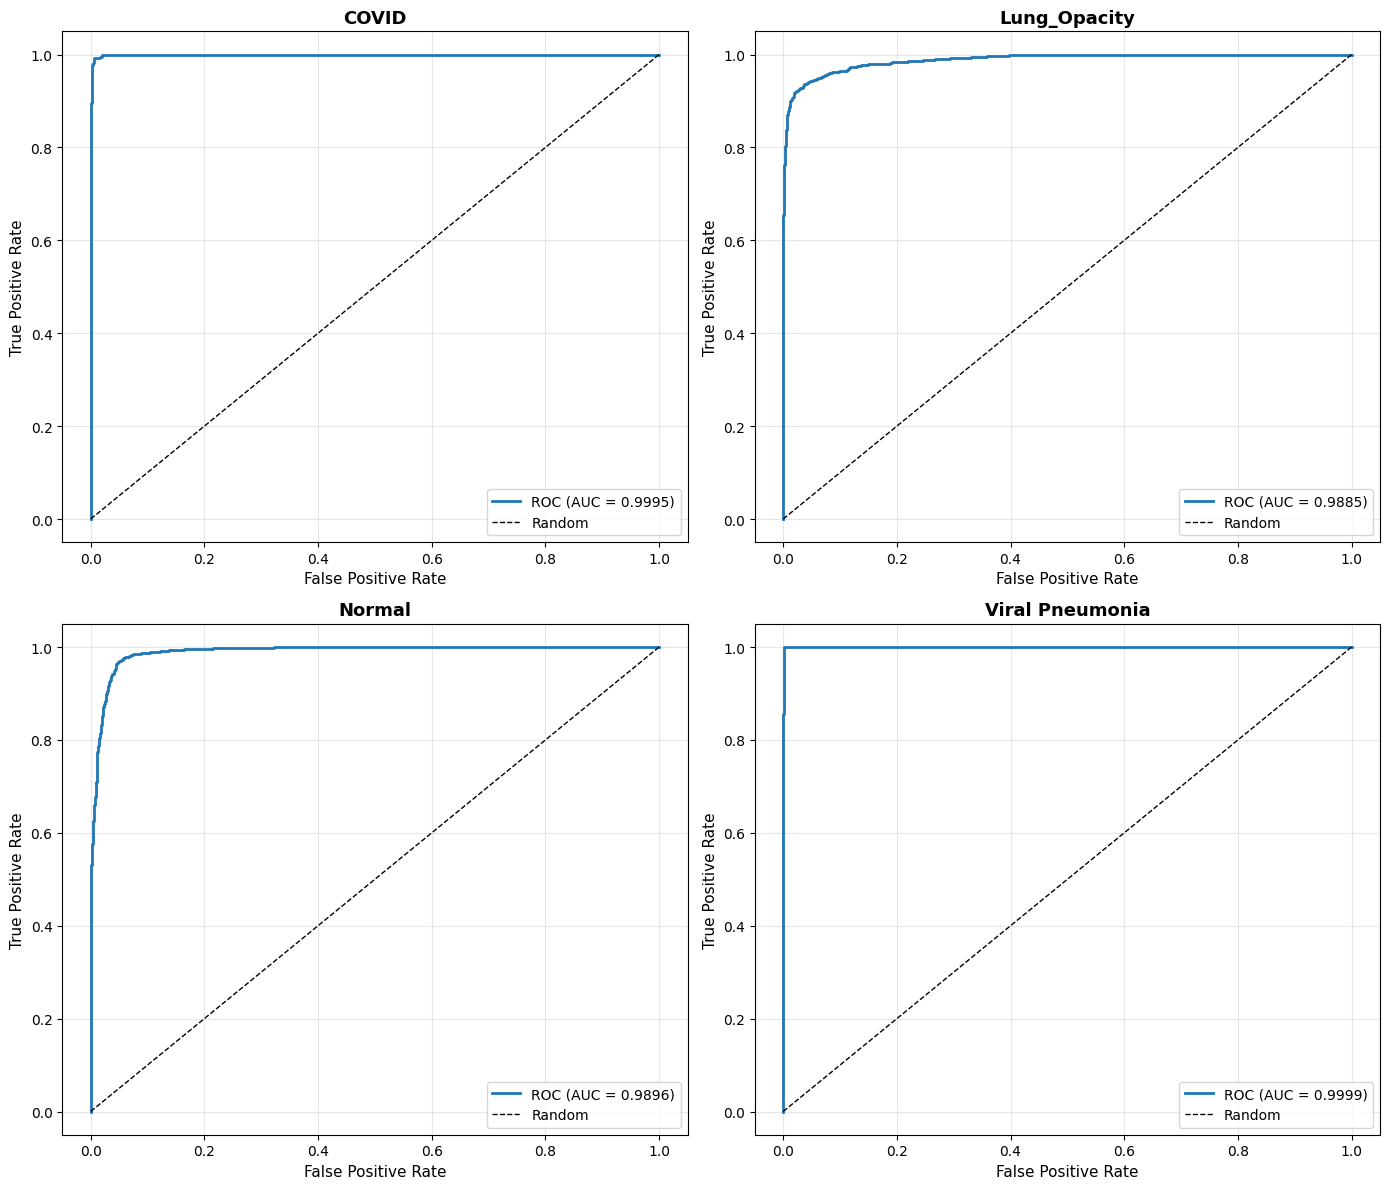

In [9]:
# Cell 8: ROC Curves
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, class_name in enumerate(CLASS_NAMES):
    # One-vs-rest
    y_true_binary = (all_labels == i).astype(int)
    y_scores = all_probs[:, i]
    
    fpr, tpr, _ = roc_curve(y_true_binary, y_scores)
    auc = auc_scores[i]
    
    axes[i].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc:.4f})')
    axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    axes[i].set_xlabel('False Positive Rate', fontsize=11)
    axes[i].set_ylabel('True Positive Rate', fontsize=11)
    axes[i].set_title(f'{class_name}', fontsize=13, fontweight='bold')
    axes[i].legend(loc='lower right')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/roc_curves_test.png', dpi=300, bbox_inches='tight')
plt.show()



In [10]:
# Cell 9: Clinical Metrics (Sensitivity & Specificity)
print("\n" + "="*70)
print("CLINICAL METRICS")
print("="*70)

for i, class_name in enumerate(CLASS_NAMES):
    # True Positives, False Positives, True Negatives, False Negatives
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall / TPR
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # TNR
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    print(f"\n{class_name}:")
    print(f"  Sensitivity (Recall): {sensitivity:.4f} ({sensitivity*100:.2f}%)")
    print(f"  Specificity:          {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"  PPV (Precision):      {ppv:.4f} ({ppv*100:.2f}%)")
    print(f"  NPV:                  {npv:.4f} ({npv*100:.2f}%)")

print("="*70)




CLINICAL METRICS

COVID:
  Sensitivity (Recall): 0.9761 (97.61%)
  Specificity:          0.9973 (99.73%)
  PPV (Precision):      0.9870 (98.70%)
  NPV:                  0.9951 (99.51%)

Lung_Opacity:
  Sensitivity (Recall): 0.9091 (90.91%)
  Specificity:          0.9820 (98.20%)
  PPV (Precision):      0.9524 (95.24%)
  NPV:                  0.9646 (96.46%)

Normal:
  Sensitivity (Recall): 0.9712 (97.12%)
  Specificity:          0.9460 (94.60%)
  PPV (Precision):      0.9435 (94.35%)
  NPV:                  0.9725 (97.25%)

Viral Pneumonia:
  Sensitivity (Recall): 0.9901 (99.01%)
  Specificity:          0.9987 (99.87%)
  PPV (Precision):      0.9804 (98.04%)
  NPV:                  0.9993 (99.93%)


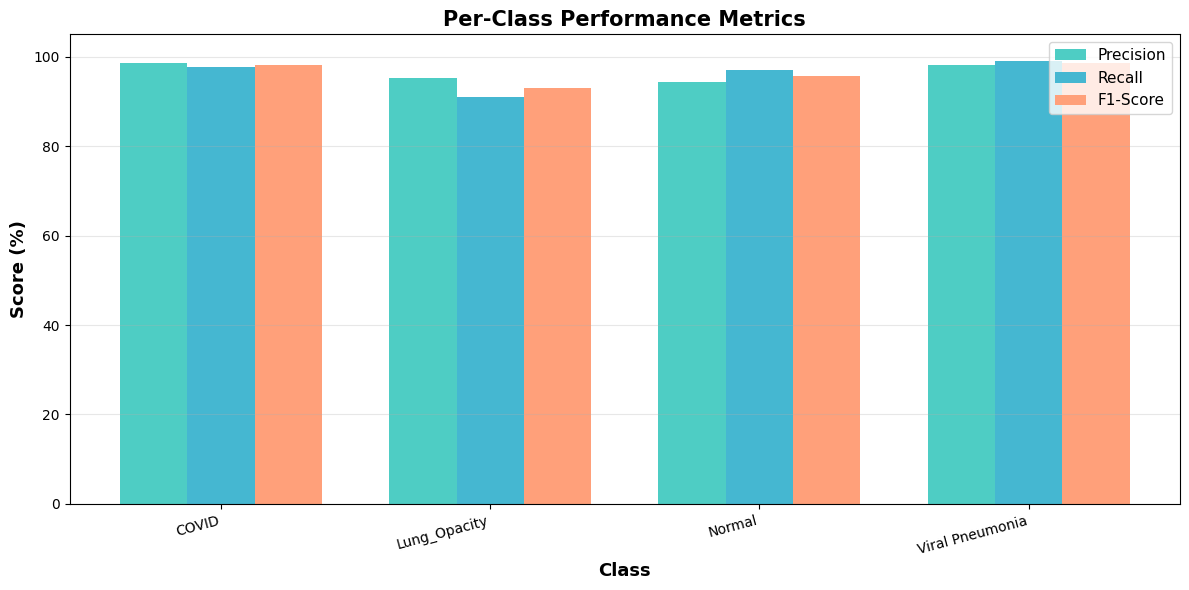

In [11]:
# Cell 10: Performance Comparison Bar Chart
metrics_comparison = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': precision_per_class * 100,
    'Recall': recall_per_class * 100,
    'F1-Score': f1_per_class * 100
})

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CLASS_NAMES))
width = 0.25

ax.bar(x - width, metrics_comparison['Precision'], width, label='Precision', color='#4ECDC4')
ax.bar(x, metrics_comparison['Recall'], width, label='Recall', color='#45B7D1')
ax.bar(x + width, metrics_comparison['F1-Score'], width, label='F1-Score', color='#FFA07A')

ax.set_xlabel('Class', fontsize=13, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=13, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.savefig('../results/plots/metrics_comparison_test.png', dpi=300, bbox_inches='tight')
plt.show()


In [12]:

# Cell 11: Final Summary
print("\n" + "="*70)
print("TEST SET EVALUATION SUMMARY")
print("="*70)
print(f"\nDataset: {len(all_labels)} test images")
print(f"Model: ResNet50 (96.13% validation accuracy)")
print(f"\nTest Set Performance:")
print(f"  Overall Accuracy: {accuracy*100:.2f}%")
print(f"  Average Precision: {precision:.4f}")
print(f"  Average Recall: {recall:.4f}")
print(f"  Average F1-Score: {f1:.4f}")
print(f"  Average ROC-AUC: {avg_auc:.4f}")

print(f"\nBest Performing Class:")
best_class_idx = np.argmax(f1_per_class)
print(f"  {CLASS_NAMES[best_class_idx]}: F1={f1_per_class[best_class_idx]:.4f}")

print(f"\nMost Challenging Class:")
worst_class_idx = np.argmin(f1_per_class)
print(f"  {CLASS_NAMES[worst_class_idx]}: F1={f1_per_class[worst_class_idx]:.4f}")

print("\n" + "="*70)
print("✅ Complete test evaluation finished!")
print("\nGenerated files:")
print("  - test_set_performance.csv")
print("  - confusion_matrix_test.png")
print("  - confusion_matrix_normalized_test.png")
print("  - roc_curves_test.png")
print("  - metrics_comparison_test.png")
print("="*70)


TEST SET EVALUATION SUMMARY

Dataset: 3176 test images
Model: ResNet50 (96.13% validation accuracy)

Test Set Performance:
  Overall Accuracy: 95.56%
  Average Precision: 0.9558
  Average Recall: 0.9556
  Average F1-Score: 0.9554
  Average ROC-AUC: 0.9944

Best Performing Class:
  Viral Pneumonia: F1=0.9852

Most Challenging Class:
  Lung_Opacity: F1=0.9302

✅ Complete test evaluation finished!

Generated files:
  - test_set_performance.csv
  - confusion_matrix_test.png
  - confusion_matrix_normalized_test.png
  - roc_curves_test.png
  - metrics_comparison_test.png
